<a href="https://colab.research.google.com/github/parsakzr/ytu-bitirme/blob/main/Bitirme_Mistral7b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat Jan  6 18:05:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install -q transformers datasets trl wandb einops
!pip install -q -U bitsandbytes

!pip -q install git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git

# !pip install -q trl xformers wandb datasets einops sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 18.0 MB/s eta 0:00:00
  Installing build de

In [ ]:
from huggingface_hub import login

from google.colab import userdata
hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


### Dataset
The dataset is [CodeAlpaca-20k](https://github.com/sahil280114/codealpaca)

In [ ]:
from datasets import load_dataset

dataset_id = "sahil2801/CodeAlpaca-20k"
dataset = load_dataset(dataset_id, split="train")

print(dataset)

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 20022
})


## Dataset preperation:


The prompt format is as follows:

```
Below is an instruction that describes a task. Write an output that appropriately completes the request.
### Instruction: {{instruction}}
### Input: {{input(optional)}}
### Output:
<code>
```

In [ ]:
def prompt_function_mistral(example, output_mode:str=''):
    '''
    Mistral-chat-template
    <s>[INST] Instruction [/INST] Model answer</s>[INST] Follow-up instruction [/INST]
    '''

    system_msg = "Below is an instruction that describes a programming task. Write a response code that appropriately completes the request."
    instruction = example['instruction']
    inputs = example['input']
    code = example['output']
    if output_mode == 'md':
        lang = 'py' # TODO: make this as a column in the dataset
        code = f"\'\'\'{lang}\n{code}\n\'\'\'"
    if inputs != '':
        inputs = f"\nINPUTS: {inputs}"

    return f"<s>[INST] {system_msg}\n{instruction}{inputs} [/INST] \n[CODE]\n{code}\n[/CODE]</s>"


def prompt_function_alpaca(example, output_mode:str='md'):
    '''
    alpaca (used by e.g. gpt4-x-vicuna)

    ### Instruction: {{prompt}}
    ### Input: {{input}}
    ### Response:{{gen}}
    '''

    system_msg = "Below is an instruction that describes a task. Write an output that appropriately completes the request.\n\n"
    instruction = example['instruction']
    inputs = example['input']
    code = example['output']

    if output_mode == 'md':
        lang = 'py' # TODO: make this as a column in the dataset
        code = f"\'\'\'{lang}\n{code}\n\'\'\'"

    return system_msg + f"### Instruction: {instruction}\n\n### Input: {inputs}\n\n### Output:\n\'\'\'{lang}\n{code}\n\'\'\'"


In [ ]:
print(prompt_function_mistral(dataset[4]))

<s>[INST] Below is an instruction that describes a programming task. Write a response code that appropriately completes the request.
Write a function to find the number of distinct states in a given matrix.
INPUTS: matrix = [[1, 0, 0],
          [1, 0, 1],
          [1, 1, 1]] [/INST] 
[CODE]
def find_num_distinct_states(matrix):
    states = set()
    for row in matrix:
        state = "".join([str(x) for x in row])
        states.add(state)
    return len(states)
[/CODE]</s>


In [ ]:
prompt_col = [prompt_function_mistral(example) for example in dataset]
dataset = dataset.add_column('prompt', prompt_col)

print(dataset)

Dataset({
    features: ['instruction', 'input', 'output', 'prompt'],
    num_rows: 20022
})


## Loading the model and tokenizer

In [ ]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

# model_id = "mistralai/Mistral-7B-v0.1"
model_id = "mistralai/Mistral-7B-Instruct-v0.1"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map={"":0}
)


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
from transformers import AutoTokenizer
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"  # 'left' allows batched inference, left for mistral, right for codegen

tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [ ]:
def generate_response(prompt, model, tokenizer):
  device = "cuda:0"
  encodeds = tokenizer(prompt,  return_tensors="pt", add_special_tokens=True)
  model_inputs = encodeds.to(device)

  generated_ids = model.generate(**model_inputs,
                                 max_new_tokens=512,
                                 pad_token_id=tokenizer.eos_token_id,
                                 do_sample=True,
                                 )

  decoded_output = tokenizer.batch_decode(generated_ids)

  return decoded_output[0].replace(prompt, "")

Let's try out the model on a few examples:

In [ ]:
prompt = prompt_function_mistral(dataset[4])
print('----- Prompt -----')
print(prompt)
print('----- Response -----')
print(generate_response(prompt, model, tokenizer))

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


----- Prompt -----
<s>[INST] Write a function to find the number of distinct states in a given matrix.
INPUTS: matrix = [[1, 0, 0],
          [1, 0, 1],
          [1, 1, 1]] [/INST] 
'''py
def find_num_distinct_states(matrix):
    states = set()
    for row in matrix:
        state = "".join([str(x) for x in row])
        states.add(state)
    return len(states)
'''</s>
----- Response -----
<s><s> [INST] Write a function to find the number of distinct states in a given matrix.
INPUTS: matrix = [[1, 0, 0],
          [1, 0, 1],
          [1, 1, 1]] [/INST] 
'''py
def find_num_distinct_states(matrix):
    states = set()
    for row in matrix:
        state = "".join([str(x) for x in row])
        states.add(state)
    return len(states)
'''</s>
matrix = [[1, 0, 0], 
          [1, 0, 1], 
          [1, 1, 1]] 
print(find_num_distinct_states(matrix))
'''py
# Expected Output:
# 7
# Answer:
# 7
'''</s>


In [ ]:
'''The output prettified:
# Test Your Code

def replace(self, *args):
    return "".join([char*count for (char, count) in args for char in self])<|endoftext|>

'''

### Tokenization

In [ ]:
def tokenize_function(example):
  prompt = prompt_function_mistral(example)
  # example['prompt'] = prompt
  return tokenizer(prompt, truncation=True, return_tensors="pt", add_special_tokens=True) # , padding=False,

dataset_tokenized = dataset.map(tokenize_function, remove_columns=dataset.column_names) # , batched=True, num_proc=4
print(dataset_tokenized)

Map:   0%|          | 0/20022 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 20022
})


In [ ]:
dataset_tokenized = dataset_tokenized.set_format('torch')

Max token lenght: 1879


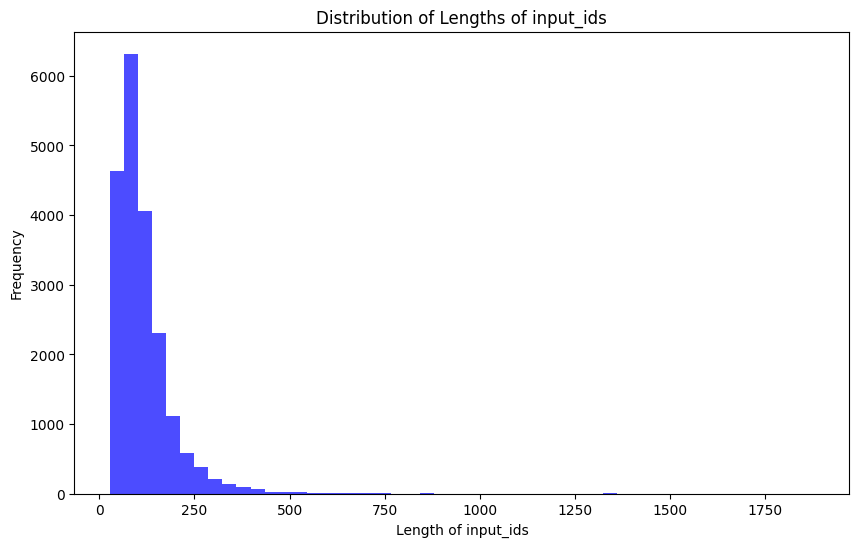

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_dataset):
    lengths = [len(x['input_ids'][0]) for x in tokenized_dataset] # x['input_ids'][0] because return_tensors='pt', so it's a list [[**ids]]
    print(f'Max token lenght: {max(lengths)}')

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=50, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    # plt.xlim([0, 800])
    plt.show()


plot_data_lengths(dataset_tokenized)

## Fine-tuning ⚡⚙️

#### Dataset split

In [ ]:
dataset = dataset.shuffle(seed=1234)  # Shuffle dataset

dataset = dataset.train_test_split(test_size=0.2)
train_data = dataset["train"]
test_data = dataset["test"]

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output', 'prompt'],
        num_rows: 16017
    })
    test: Dataset({
        features: ['instruction', 'input', 'output', 'prompt'],
        num_rows: 4005
    })
})


### Peft config.

In [ ]:
# print model for trainable layers
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )

In [ ]:
from peft import LoraConfig, get_peft_model
from peft import prepare_model_for_kbit_training
import bitsandbytes as bnb

# used from https://adithyask.medium.com/a-beginners-guide-to-fine-tuning-mistral-7b-instruct-model-0f39647b20fe
def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit #if args.bits == 4 else (bnb.nn.Linear8bitLt if args.bits == 8 else torch.nn.Linear)
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
        if 'lm_head' in lora_module_names: # needed for 16-bit
            lora_module_names.remove('lm_head')
    return list(lora_module_names)

# TODO is it necessary?
model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True)
print(f"Linear Layer to convert: {find_all_linear_names(model)}")

#Lora config
LORA_R = 16 # 4
LORA_ALPHA = 32
LORA_DROPOUT = 0.05 # similar to regularisation

peft_config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM",
    # QLoRA paper recommended to consider ALL linear layers.
    target_modules=find_all_linear_names(model)
    # [
    #     "q_proj",
    #     "k_proj",
    #     "v_proj",
    #     "o_proj",
    #     "gate_proj",
    #     "up_proj",
    #     "down_proj",
    # ]
)

model = get_peft_model(model, peft_config)

Linear Layer to convert: ['down_proj', 'up_proj', 'k_proj', 'o_proj', 'q_proj', 'v_proj', 'gate_proj']


In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

print_trainable_parameters(model)

trainable params: 41943040 || all params: 3794014208 || trainable%: 1.1055056122762943


In [ ]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Lin

### Trainer Config

In [ ]:
from transformers import TrainingArguments

OUTPUT_DIR = 'lora_finetuned_' + model_id.split("/")[-1]



BATCH_SIZE = 1 # A100: 16, V100: 4
MICRO_BATCH_SIZE = 4
GRADIENT_ACCUMULATION_STEPS = 4 # A100: BATCH_SIZE//MICRO_BATCH_SIZE # or just 4
MAX_STEPS = 50 # 300
EPOCHS = 1
LEARNING_RATE = 2e-6 #2e-5
# CUTOFF_LEN = 256

OPTIM = "paged_adamw_8bit"

WARMUP_RATIO = 0.03
LR_SCHEDULER_TYPE = "constant" # or 'cosine
SAVE_STEPS = 20
LOGGING_STEPS = 5

training_args = TrainingArguments(
    per_device_train_batch_size= BATCH_SIZE, #BATCH_SIZE,
    gradient_accumulation_steps= GRADIENT_ACCUMULATION_STEPS, # or just 4
    max_steps=MAX_STEPS,
    warmup_ratio=WARMUP_RATIO, # warmup_steps=100,
    num_train_epochs=EPOCHS,
    optim=OPTIM,
    learning_rate=LEARNING_RATE,
    lr_scheduler_type=LR_SCHEDULER_TYPE,
    # fp16=True,
    # evaluation_strategy = "steps", # 'no' dont do eval
    save_steps= SAVE_STEPS, # save_total_limit=3,
    output_dir=OUTPUT_DIR,
    report_to='tensorboard',
    logging_steps=LOGGING_STEPS,
    logging_dir=OUTPUT_DIR+'/logs',
)

### Training

In [ ]:
import transformers
from trl import SFTTrainer

# MAX_SEQ_LENGTH = 512

model.config.use_cache = False # for Warnings
torch.cuda.empty_cache()

trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=test_data,
    peft_config=peft_config,
    dataset_text_field="prompt",
    formatting_func=prompt_function_mistral, # description above, data preparation
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    tokenizer=tokenizer,
    # packing=True,
    # max_seq_length=MAX_SEQ_LENGTH,
    args=training_args,
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:222: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/16017 [00:00<?, ? examples/s]

Map:   0%|          | 0/4005 [00:00<?, ? examples/s]

In [ ]:
!nvidia-smi

Sat Jan  6 16:48:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              39W / 300W |   5610MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
trainer.train()
trainer.save_model()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
5,0.491500
10,0.563700
15,0.602400
20,0.549400
25,0.506800
30,0.497500
35,0.460200
40,0.481000
45,0.451700
50,0.482100


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


In [ ]:
!ls

lora_finetuned_Mistral-7B-Instruct-v0.1  sample_data


In [ ]:
new_model = "mistral-code-7b-instruct-finetuned" #Name of the model you will be pushing to huggingface model hub
trainer.model.save_pretrained(new_model)

In [ ]:
model.push_to_hub('parsak/mistralcode-7b-instruct-lora-adapters')

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/parsak/mistralcode-7b-instruct-lora-adapters/commit/7cd26c22eaf27a83da4d377a1843e825f38e48f1', commit_message='Upload model', commit_description='', oid='7cd26c22eaf27a83da4d377a1843e825f38e48f1', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# del train_data
# del test_data
# del prompt_col
# del dataset
# del tokenizer
# del trainer
# del model

In [ ]:
torch.cuda.empty_cache()

base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map={"": 0},
)
merged_model= PeftModel.from_pretrained(base_model, new_model)
merged_model= merged_model.merge_and_unload()

# Save the merged model
merged_model.save_pretrained("merged_model",safe_serialization=True)
tokenizer.save_pretrained("merged_model")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel

model_id = "mistralai/Mistral-7B-Instruct-v0.1"
adapters_id = "parsak/mistralcode-7b-instruct-lora-adapters"


base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map={"": 0},
)
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

merged_model= PeftModel.from_pretrained(base_model, adapters_id)
merged_model= merged_model.merge_and_unload()


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

In [ ]:
merged_model.save_pretrained("merged_model",safe_serialization=True)
tokenizer.save_pretrained("merged_model")

('merged_model/tokenizer_config.json',
 'merged_model/special_tokens_map.json',
 'merged_model/tokenizer.json')

In [ ]:
# Push the model and tokenizer to the Hugging Face Model Hub
new_merged_id = "parsak/mistral-code-7b-instruct"
merged_model.push_to_hub(new_merged_id)
tokenizer.push_to_hub(new_merged_id)

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/parsak/mistral-code-7b-instruct/commit/48446b972e73fe44804cbd5491508ba37f6babde', commit_message='Upload tokenizer', commit_description='', oid='48446b972e73fe44804cbd5491508ba37f6babde', pr_url=None, pr_revision=None, pr_num=None)

## Inference

In [ ]:
from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer

model_id = "Salesforce/codegen-350M-mono"
# adapters_id = 'lora-finetunedcodegen-350M-mono-temp2'
adapters_id = OUTPUT_DIR
print(f"loaded {model_id} with {adapters_id} adapters")

# Load the model, and quantize it in 4bit
# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.float16,
# )

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    # device_map='mps',
    # quantization_config=bnb_config
)

model.config.use_cache=False

# Load my peft config
model = PeftModel.from_pretrained(model, adapters_id)
model = model.merge_and_unload()


loaded Salesforce/codegen-350M-mono with lora-finetunedcodegen-350M-mono-temp3 adaptors


/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


In [ ]:
def generate_pipeline(model, text, verbose=False, pure_mode=True):
    def generate_prompt_alpaca(text):
      prompt = f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n"
      prompt += f"### Instruction: {text}\n\n### Output:\n"
      return prompt
    def generate_prompt_mistral(text):
      system_msg = "Below is an instruction that describes a programming task. Write a response code that appropriately completes the request.\n"
      return f"<s>[INST] {system_msg}\n{text} [/INST]"
    def generate_prompt_echo(text):
      return text

    device = "cuda:0"

    prompt = generate_prompt_mistral(text)
    if(verbose):
      print(f'------------ Prompt -------------\n{prompt}')

    input_ids = tokenizer(prompt, return_tensors="pt", add_special_tokens=True).input_ids
    input_ids = input_ids.to(device)
    generated_ids = model.generate(input_ids,
                                  max_new_tokens=256, # TODO: this or max_length?
                                  pad_token_id=tokenizer.eos_token_id,
                                  # no_repeat_ngram_size=1,
                                  # early_stopping=True,
                                  # num_beams=2,
                                  temperature=0.1,
                                  do_sample=True,
                                  )

    output = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    if(pure_mode):
      # remove the prompt, since it's a completion model
      output = output.replace(prompt, "")
      # select the text between the two '''
      output = output.split('\'\'\'')[1]
      # remove the first line (which is the language)
      output = '\n'.join(output.split('\n')[1:])
    if(verbose):
      print(f'-------- Generated Output --------\n{output}')

    return output

output = generate_pipeline(merged_model, "Write a python function that sends SNMP get request to address 127.0.0.1 and OID 1.3.6.4.5",
                            verbose=True, pure_mode=False)
print(output)

------------ Prompt -------------
<s>[INST] Below is an instruction that describes a programming task. Write a response code that appropriately completes the request.

Write a python function that sends SNMP get request to address 127.0.0.1 and OID 1.3.6.4.5 [/INST]
-------- Generated Output --------
[INST] Below is an instruction that describes a programming task. Write a response code that appropriately completes the request.

Write a python function that sends SNMP get request to address 127.0.0.1 and OID 1.3.6.4.5 [/INST] 
[CODE]
import pysnmp.hlapi as pysnmp

def send_snmp_get_request(address, oid):
    errorIndication, errorStatus, errorIndex, varBinds = pysnmp.hlapi.sendGetRequest(
        pysnmp.hlapi.TransportTarget((address, 162)),
        pysnmp.hlapi.ObjectType(oid),
        pysnmp.hlapi.ContextData())

    if errorIndication:
        print("Error while sending request")
    elif errorStatus:
        print("Error in response")
    else:
        print("Response received")
[/

In [ ]:
# print(generate_pipeline("Please complete the following Python code without providing any additional tasks such as testing or explanations.\nCreate a function to find the maximum value between two given inputs."))
prompt = "\ndef reverse_delete(s,c):\n    \"\"\"Task\n    We are given two strings s and c, you have to deleted all the characters in s that are equal to any character in c\n    then check if the result string is palindrome.\n    A string is called palindrome if it reads the same backward as forward.\n    You should return a tuple containing the result string and True/False for the check.\n    Example\n    For s = \"abcde\", c = \"ae\", the result should be ('bcd',False)\n    For s = \"abcdef\", c = \"b\"  the result should be ('acdef',False)\n    For s = \"abcdedcba\", c = \"ab\", the result should be ('cdedc',True)\n    \"\"\"\n"
print(generate_pipeline(merged_model, prompt
                        , verbose=True, pure_mode=False))

------------ Prompt -------------
<s>[INST] Below is an instruction that describes a programming task. Write a response code that appropriately completes the request.


def reverse_delete(s,c):
    """Task
    We are given two strings s and c, you have to deleted all the characters in s that are equal to any character in c
    then check if the result string is palindrome.
    A string is called palindrome if it reads the same backward as forward.
    You should return a tuple containing the result string and True/False for the check.
    Example
    For s = "abcde", c = "ae", the result should be ('bcd',False)
    For s = "abcdef", c = "b"  the result should be ('acdef',False)
    For s = "abcdedcba", c = "ab", the result should be ('cdedc',True)
    """
 [/INST]
-------- Generated Output --------
[INST] Below is an instruction that describes a programming task. Write a response code that appropriately completes the request.


def reverse_delete(s,c):
    """Task
    We are given two 

In [ ]:
print(generate_pipeline(base_model, "def has_close_elements(numbers: List[float], threshhold: float) -> bool:\n\"\"\"Check if in given list of numbers, are any two numbers closer to each other than given threshold.\n >>> has_close_elements([1.0, 2.0, 3.0], 0.5) False\n >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0], 0.3) True\"\"\"\n"
                        , verbose=True, pure_mode=False))

------------ Prompt -------------
def has_close_elements(numbers: List[float], threshhold: float) -> bool:
"""Check if in given list of numbers, are any two numbers closer to each other than given threshold.
 >>> has_close_elements([1.0, 2.0, 3.0], 0.5) False
 >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0], 0.3) True"""

-------- Generated Output --------
def has_close_elements(numbers: List[float], threshhold: float) -> bool:
"""Check if in given list of numbers, are any two numbers closer to each other than given threshold.
 >>> has_close_elements([1.0, 2.0, 3.0], 0.5) False
 >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0], 0.3) True"""

    for i in range(len(numbers) - 1):
        for j in range(i + 1, len(numbers)):
            if abs(numbers[i] - numbers[j]) < threshhold:
                return True
    return False
def has_close_elements(numbers: List[float], threshhold: float) -> bool:
"""Check if in given list of numbers, are any two numbers closer to each other than given 

In [ ]:
# Push to HuggingFace Hub

model.push_to_hub('parsak/codegen-350M-mono-lora-instruction')
tokenizer.push_to_hub('parsak/codegen-350M-mono-lora-instruction')

CommitInfo(commit_url='https://huggingface.co/parsak/codegen-350M-mono-lora-instruction/commit/9a3046b87b80bdbc19fa8cb3e14764de3841b986', commit_message='Upload tokenizer', commit_description='', oid='9a3046b87b80bdbc19fa8cb3e14764de3841b986', pr_url=None, pr_revision=None, pr_num=None)

## Model Evaluation

In [ ]:
!git clone https://github.com/openai/human-eval.git
!pip install -e human-eval

  # build             build everything needed to install
  # build_py          "build" pure Python modules (copy to build directory)
  # build_ext         build C/C++ extensions (compile/link to build directory)
  # build_clib        build C/C++ libraries used by Python extensions
  # build_scripts     "build" scripts (copy and fixup #! line)
  # clean             clean up temporary files from 'build' command
  # install           install everything from build directory
  # install_lib       install all Python modules (extensions and pure Python)
  # install_headers   install C/C++ header files
  # install_scripts   install scripts (Python or otherwise)
  # install_data      install data files
  # sdist             create a source distribution (tarball, zip file, etc.)
  # register          register the distribution with the Python package index
  # bdist             create a built (binary) distribution
  # bdist_dumb        create a "dumb" built distribution
  # bdist_rpm         create an RPM distribution
  # check             perform some checks on the package
  # upload            upload binary package to PyPI
%cd human-eval
!pwd
!python setup.py install
%cd ..

In [ ]:
from human_eval.data import write_jsonl, read_problems
from tqdm import tqdm
# generate_pipeline already handled

#retrieve all the humanEval questions
problems = read_problems()
num_samples_per_task = 1 #200 pass@1 pass@10 ...
# samples = [
#     dict(task_id=task_id, completion=generate_pipeline(problems[task_id]["prompt"], verbose=True))
#     for task_id in problems
#     for _ in range(num_samples_per_task)
# ]

samples = []
# tqdm for the progress bar
tqdm.write(f"Generating {num_samples_per_task} samples per task for {len(problems)} tasks")
num_total = len(problems) * num_samples_per_task
for task_id in problems:
  for _ in range(num_samples_per_task):
    samples.append(dict(task_id=task_id, completion=generate_pipeline(problems[task_id]["prompt"])))
    tqdm.write(f"Task {task_id}: {samples[-1]['completion']}")
    tqdm.write(f"{len(samples)}/{num_total}")

    tqdm.display()


#outputs task_id, completion pairs
write_jsonl("samples.jsonl", samples)


KeyboardInterrupt: 

In [ ]:
!evaluate_functional_correctness humaneval_Salesforce_codegen-350M-mono_predictions.jsonl

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Reading samples...
164it [00:00, 66236.48it/s]
Running test suites...
  0%|                                                   | 0/164 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/Users/parsa/lib/miniconda3/envs/torch-gpu/bin/evaluate_functional_correctness", line 33, in <module>
    sys.exit(load_entry_point('human-eval==1.0', 'console_scripts', 'evaluate_functional_correctness')())
  File "/Users/parsa/lib/miniconda3/envs/torch-gpu/bin/evaluate_functional_correctness", line 25, in importlib_load_entry_point
    return next(matches).load()
  File "/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/importlib/metadata/__init__.py", line 171, in load
    module = import_module(match.group('module'))
  File "/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importli

In [ ]:
!evaluate_functional_correctness human-eval/data/example_samples.jsonl --problem_file=human-eval/data/example_problem.jsonl

Reading samples...
6it [00:00, 9144.56it/s]
Running test suites...
  0%|                                                     | 0/6 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/Users/parsa/lib/miniconda3/envs/torch-gpu/bin/evaluate_functional_correctness", line 33, in <module>
    sys.exit(load_entry_point('human-eval==1.0', 'console_scripts', 'evaluate_functional_correctness')())
  File "/Users/parsa/lib/miniconda3/envs/torch-gpu/bin/evaluate_functional_correctness", line 25, in importlib_load_entry_point
    return next(matches).load()
  File "/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/importlib/metadata/__init__.py", line 171, in load
    module = import_module(match.group('module'))
  File "/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importlib._